# HuBMAP 

The $HuBMAP$ $-$ $Hacking$ $the$ $Human$ $Vasculature$ $competition$ is a $Kaggle$ $competition$ that challenges participants to `develop machine learning models to segment microvascular structures` in $2D$ `PAS-stained histology images` from healthy human kidney tissue slides. The goal of the competition is to `improve researchers' understanding of how the blood vessels are arranged in human tissues`.

The competition is hosted by the $Human$ $BioMolecular$ $Atlas$ $Program$ $HuBMAP$, which is a `global effort to create a comprehensive and open-access atlas of human cells`. $HuBMAP$ researchers are using the `latest molecular and cellular biology technologies` to `study the connections that cells have with each other` throughout the body.

The `microvascular structures` that are being segmented in this competition `include` 
* $Capillaries$
* $Arterioles$
* $Venules$

These structures are `very small` and `difficult to see with the naked eye`, so `automated segmentation methods are essential` for researchers to study them.

**[National effort to focus on mapping human body on cellular level](https://www.purdue.edu/newsroom/releases/2019/Q4/national-effort-to-focus-on-mapping-human-body-on-cellular-level.html)**

<img src = "https://i.imgflip.com/ecoso.jpg">

In [1]:
! pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=f68143606ae677c77484e66fe84422b77ab763039a77357c37741bf3f617ca12
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=774c671a49d219a2713e81a823cee79180b32ed1997c510f6f22c0b037fd11a3
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built ef

In [2]:
import numpy as np 
import pandas as pd 

In [3]:
import matplotlib.pyplot as plt
from IPython.display import IFrame
import tqdm

In [4]:
import json
import cv2
from PIL import Image

In [5]:
from kaggle_secrets import UserSecretsClient

In [6]:
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [8]:
import torch
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp
import torch.nn as nn 

# 1 | Data 🚀

The images are $256x256$ pixels in `size` and are in the `.tif` format. The images are a `diverse set` of images from `different patients` and `different tissue slides`.

The `ground truth segmentation` for the `images` in the data set was created by a `team of experts`. The experts used a `variety of techniques` to create the ground truth segmentation
* Manual segmentation
* Semi-automatic segmentation. 

The ground truth segmentation is accurate and reliable, and it is essential for training machine learning models to segment microvascular structures.

In [9]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hubmap-hacking-the-human-vasculature/sample_submission.csv
/kaggle/input/hubmap-hacking-the-human-vasculature/tile_meta.csv
/kaggle/input/hubmap-hacking-the-human-vasculature/wsi_meta.csv
/kaggle/input/hubmap-hacking-the-human-vasculature/polygons.jsonl
/kaggle/input/hubmap-hacking-the-human-vasculature/test/72e40acccadf.tif
/kaggle/input/hubmap-hacking-the-human-vasculature/train/2dac08665dd3.tif
/kaggle/input/hubmap-hacking-the-human-vasculature/train/401cc7fbcf22.tif
/kaggle/input/hubmap-hacking-the-human-vasculature/train/db4621c7226b.tif
/kaggle/input/hubmap-hacking-the-human-vasculature/train/e30f64761d6b.tif
/kaggle/input/hubmap-hacking-the-human-vasculature/train/9d6734304154.tif
/kaggle/input/hubmap-hacking-the-human-vasculature/train/756efdf5b917.tif
/kaggle/input/hubmap-hacking-the-human-vasculature/train/ee49ab2b0bf2.tif
/kaggle/input/hubmap-hacking-the-human-vasculature/train/823b99840b99.tif
/kaggle/input/hubmap-hacking-the-human-vasculature/train/78f336539d

# 2 | Visualizing the Data 😎

Visualizing the data is an integral part of image models. It gives us information on what we aare actually working, and also we do this for fun. Yayyyyyyyy

Lets asusme we take this iamge as sample 

In [10]:
sample_image = cv2.imread("/kaggle/input/hubmap-hacking-the-human-vasculature/test/72e40acccadf.tif")

Lets assume we want to train a model on the dataset we have. But it is not a good idea to directly train a big model on this data. 

When we are working with the images, it is advised to first preproces the images, before sending them to any model 

By preporcessing we mostly mean that 

|_____|______
|---|---
|Resize|To ensure that all images are the same size.
||To reduce the amount of data that needs to be processed.
||To improve the accuracy of the model.
|Mean|It helps to improve the stability of the model. 
||It helps to improve the performance of the model.
||It helps to make the model more robust to changes in lighting.
|STD|It helps to improve the stability of the training process.
||It helps to improve the performance of the model. 
||It makes the model more interpretable.

We could have actually made a proper function from scratch to do these things, like this 
```
def preprocess(image):
    
    image = np.clip(image , width , height)

    image = (image - image.mean()) / image.std()

    return image
```
(this might be not correct, but just a example)

But we rather use a specialized library that is faster. The `code we just wrote` can be `very slow to work`. But `albumnetnation library` can be `fast enough`

In [11]:
A.Compose([
        A.Resize(width = 512 , height = 512) , 
        A.Normalize(
            mean = [0 , 0] , 
            std = [1 , 1] , 
            max_pixel_value = 255
        ) , 
        ToTensorV2()
    ])

Compose([
  Resize(always_apply=False, p=1, height=512, width=512, interpolation=1),
  Normalize(always_apply=False, p=1.0, mean=[0, 0], std=[1, 1], max_pixel_value=255),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

This is our `compose` block

Now lets make a proper function `display` for viewing the image

In [12]:
def display(im , augments = False):

    img = im
    
    if augments :
        
        img = A.Compose([
        A.Resize(width = 512 , height = 512) , 
        A.Normalize(
            mean = [0 , 0 , 0] , 
            std = [1 , 1 , 1] , 
            max_pixel_value = 255
        ) , 
        ToTensorV2()
    ])(image = im)["image"]

    # return image
    
    plt.imshow(tf.reshape(img , (512 , 512 , 3)))

Test Image before preprocessing : 


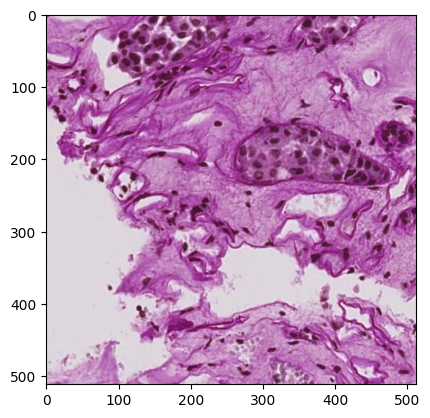

In [13]:
print("Test Image before preprocessing : ")
display(sample_image)

Test Image before preprocessing : 


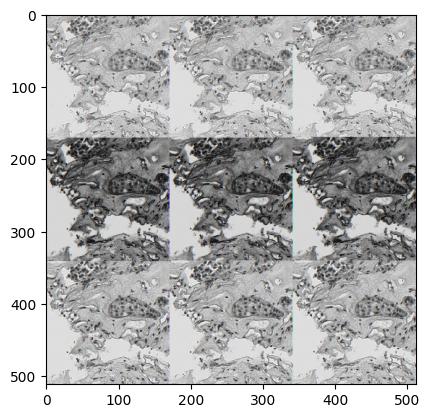

In [14]:
print("Test Image before preprocessing : ")
display(sample_image , augments = True)

# 3 | Test 🧪

Thanks to **[YASSINE ALOUINI](https://www.kaggle.com/yassinealouini)=>[Working with TIFF files](https://www.kaggle.com/code/yassinealouini/working-with-tiff-files)** for providing a simple way to work wit the `tif` files withing python environments

I have change the way of input for the image from `rasterio` to `opencv`, though it was concluded in **[YASSINE ALOUINI](https://www.kaggle.com/yassinealouini)=>[Some Insights](https://www.kaggle.com/competitions/hubmap-organ-segmentation/discussion/333389)**that `rasterio` is the fastest way 

In [15]:
test_dir = "/kaggle/input/hubmap-hacking-the-human-vasculature/test"

# 4 | Train 🚃

We also have a training data with us. The train folder only contains the image files in `tif` format. And the anootions are given in the `polygons.jsonl` format 

In [16]:
train_dir = "/kaggle/input/hubmap-hacking-the-human-vasculature/train"

# 5 | Polygons 🟥

This is a `json` file that basically contains the annotions to these data points

In [17]:
with open("/kaggle/input/hubmap-hacking-the-human-vasculature/sample_submission.csv" , "r") as f:
    k = list(f)
print(k[0])

id,height,width,prediction_string



# 6 | DataLoader 📖

A data loader is a tool that helps to load data into a deep learning model. It is used to break down the data into smaller batches, which can then be processed by the model more efficiently. Data loaders can also be used to shuffle the data, which can help to improve the performance of the model.

The `DataLoader` we are going to create here, is highly inspired by **[Thomas Rochefort-Beaudoin](https://www.kaggle.com/thomasrochefort)=>[HuBMAP : Simple PyTorch DataLoade](https://www.kaggle.com/code/thomasrochefort/hubmap-simple-pytorch-dataloader/notebook)**

* We simply first read the `json files`
* Then we get the images from the set
* Then according to the coordinates in the `json_file`. We mask the blood vessels. 
* The we return the image and the mask

Blood vessels are often masked in medical imaging competitions to make the task of identifying other objects in the image more challenging. This is because blood vessels can be very similar in appearance to other objects, such as tumors or lesions. Masking the blood vessels forces the model to focus on the other objects in the image, and to learn to distinguish them from the blood vessels. This can lead to more accurate and reliable detection of other objects in the image.

In [18]:
a = A.Compose([
        A.Resize(width = 512 , height = 512) , 
        A.Normalize(
            mean = [0 , 0 , 0] , 
            std = [1 , 1 , 1] , 
            max_pixel_value = 255
        ) , 
        ToTensorV2()
    ])

In [19]:
class hubmapDataset(Dataset):
    
    def __init__(self, image_dir, labels_file , augments = False):
        
        with open(labels_file, 'r') as json_file:
            self.json_labels = [json.loads(line) for line in json_file]

        self.image_dir = image_dir
#         self.transform = transform
        self.augments = augments

    __len__ = lambda self : len(self.json_labels)    
        
    def __getitem__(self, idx):
        
        image_path = os.path.join(self.image_dir, f"{self.json_labels[idx]['id']}.tif")
        image = Image.open(image_path)
        
        if self.augments:
            
            image = a(image = image)["image"]
        
        mask = np.zeros((512, 512), dtype=np.float32)

        for annot in self.json_labels[idx]['annotations']:

            cords = annot['coordinates']
            
            if annot['type'] == "blood_vessel":
                
                for cord in cords:
                    
                    rr, cc = np.array([i[1] for i in cord]), np.asarray([i[0] for i in cord])
                    
                    mask[rr, cc] = 1

        image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1)  # Shape: [C, H, W]
        mask = torch.tensor(mask, dtype=torch.float32)

#         if self.transform:
#             image = self.transform(image)

        return image, mask

Now we first load our data 

In [20]:
train_dataset = hubmapDataset(image_dir = train_dir, 
                        labels_file = '../input/hubmap-hacking-the-human-vasculature/polygons.jsonl')
train_dataset

Now we load this data into a dataloader, so that we get a manipulated data that we can pass in any pytorch pipleine

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size = 4, shuffle = True)
train_dataloader

# 7 | Model Setup 🤖


The `model setup phase` of a deep learning project is the `process of defining the architecture of the model` and the `hyperparameters` that will be used to train it.

# 7.1 | Efficient Net B-7 ✨

$EfficientNet$ $B-7$ is a deep learning model that was developed by `Google AI` in $2019$. It is a `large model` that is designed for `image classification` tasks. $EfficientNet B-7$ achieves `state-of-the-art accuracy on ImageNet`, while being `more efficient` than previous models.

$EfficientNet$ $B-7$ is based on the $EfficientNet$ architecture, which was proposed in the paper "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks" by `Mingxing Tan` and `Quoc V. Le`. The $EfficientNet$ architecture is a `compound scaling method` that `uniformly scales all dimensions` of `depth/width/resolution` using a simple yet highly effective `compound coefficient`.

$EfficientNet$ $B-7$ has $237$ layers and $1.54M$ parameters. It is trained on the `ImageNet` dataset, $EfficientNet$ $B-7$ achieves an accuracy of $84.4$% on the $ImageNet$ validation set.

$EfficientNet$ $B-7$ is a powerful model that can be used for a variety of `image classification` tasks. It is more `accurate and efficient` than previous models, making it a good choice for a variety of applications.

The model setup is highly inspired by **[
IMVision](https://www.kaggle.com/imvision12)=>[[Training] - Hubmap EfficientNet](https://www.kaggle.com/code/imvision12/training-hubmap-efficientnet)**

In [22]:
u_net = smp.Unet(encoder_name = "efficientnet-b3" , encoder_weights = "imagenet" , activation = "sigmoid")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 184MB/s]


In [23]:
# u_net = u_net.cuda()

In [24]:
u_net.train()
train_loss = 0 
score = 0

# 7.2 | Deep Lab V3

$DeepLab V3$ is a `semantic segmentation` architecture that `improves` upon $DeepLabV2$ with `several modifications`. To handle the problem of `segmenting objects at multiple scales`, modules are designed which employ `atrous convolution` in cascade or in `parallel to capture multi-scale context by adopting multiple atrous rates`. Furthermore, the $Atrous$ $Spatial$ $Pyramid$ $Pooling$ module from $DeepLabV2$ augmented with `image-level` features `encoding global context` and further `boost performance`. $DeepLab$ $V3$ has been shown to `achieve state-of-the-art` results on a variety of `semantic segmentation benchmarks`, including the $Cityscapes$. $DeepLab$ $V3$ is a powerful tool for `semantic segmentation`

In [25]:
deep_lab_v3 = torch.hub.load('pytorch/vision:v0.10.0' , 'deeplabv3_resnet50', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 224MB/s]


In [26]:
deep_lab_v3 = deep_lab_v3.train()
#deep_vab_v3 = deep_lab_v3.cuda()

# 8 | Losses 🥲

Loss functions are used to measure the difference between the predicted output of a model and the ground truth. The loss function is used to calculate the gradient of the error with respect to the model parameters, which is then used to update the parameters using an optimization algorithm.

## 8.1 | DiceLoss

Dice loss is a loss function used in image segmentation tasks. It is a measure of the similarity between two sets of data, and it is often used to train deep learning models for image segmentation.

```
Dice loss = 1 - 2 * (intersection / (union + smooth))
```

## 8.2 | Soft BCE With Logits Loss

SoftBCEWithLogitsLoss is a loss function that is used for semantic segmentation tasks. It is a smooth version of the binary cross-entropy loss function, which is more robust to outliers and can help to improve the performance of segmentation models.

```
loss = -(y * log(p) + (1 - y) * log(1 - p))

```

In [27]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        
        super(CustomLoss,self).__init__()
        
        self.diceloss = smp.losses.DiceLoss(mode='binary')
        self.binloss = smp.losses.SoftBCEWithLogitsLoss(reduction = 'mean' , smooth_factor = 0.1)

    def forward(self, output, mask):
        
        output = torch.squeeze(output)
        mask = torch.squeeze(mask)
        
        dice = self.diceloss(output , mask)
        bce = self.binloss(output , mask)
        
        loss = dice * 0.7 + bce * 0.3
        
        return loss

In [28]:
class DiceCoef(nn.Module):
    
    def __init__(self, weight=None, size_average=True):
    
        super().__init__()

    def forward(self, y_pred, y_true, smooth=1.):
        
        y_true = y_true.view(-1)
        y_pred = y_pred.view(-1)
        
        y_pred = torch.round((y_pred - y_pred.min()) / (y_pred.max() - y_pred.min()))
        
        intersection = (y_true * y_pred).sum()
        
        dice = (2.0 * intersection + smooth)/(y_true.sum() + y_pred.sum() + smooth)
        
        return dice

In [29]:
loss_func = CustomLoss()
dice_coe = DiceCoef()

# 9 | Optimizer 🛺

Adam is an optimization algorithm that can be used to train deep learning models. It is a stochastic gradient descent (SGD) method that uses adaptive estimation of first-order and second-order moments. This makes it more efficient than SGD, as it does not need to recalculate the learning rate for each weight update.

In [30]:
optimizer_unet = torch.optim.Adam([
    {'params': u_net.decoder.parameters(), 'lr': 5e-5}, 
    {'params': u_net.encoder.parameters(), 'lr': 8e-5},  
])

In [31]:
optimizer_dlv3 = torch.optim.Adam(deep_lab_v3.parameters(), lr=0.001)

# 10 | Training 🚃

I don't know the exact reason but even after reducing the `batch_size` to $1$, the `GPU` was facing `out of the memmory error`
```
train_dataloader = DataLoader(train_dataset, batch_size = 1 , shuffle = True)
```
Ant thus I will be commneting out the `training code`. I tried this to run on  colab and it ran perfectly. Dont know why this is happening. 

## 10.1 | U-Net Training

```
for epoch in tqdm.notebook.tqdm(range(5)):   
    torch.cuda.empty_cache()     
    model.train()
    train_loss = 0
    score = 0
        
    for data in tqdm.notebook.tqdm(train_dataloader ,total = len(train_dataloader)):
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        img, mask = data

        img = img.to("cuda")
        mask = mask.to("cuda")

        outputs = model(img)  

        loss =  loss_func(outputs , mask)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
```

```
---------------------------------------------------------------------------
OutOfMemoryError                          Traceback (most recent call last)
Cell In[31], line 15
     12 img = img.to("cuda")
     13 mask = mask.to("cuda")
---> 15 outputs = model(img)  
     17 loss =  loss_func(outputs , mask)
     19 loss.backward()

File /opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1501, in Module._call_impl(self, *args, **kwargs)
   1496 # If we don't have any hooks, we want to skip the rest of the logic in
   1497 # this function, and just call forward.
   1498 if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks or self._forward_pre_hooks
   1499         or _global_backward_pre_hooks or _global_backward_hooks
   1500         or _global_forward_hooks or _global_forward_pre_hooks):
-> 1501     return forward_call(*args, **kwargs)
   1502 # Do not call functions when jit is used
   1503 full_backward_hooks, non_full_backward_hooks = [], []

File /opt/conda/lib/python3.10/site-packages/segmentation_models_pytorch/base/model.py:29, in SegmentationModel.forward(self, x)
     25 """Sequentially pass `x` trough model`s encoder, decoder and heads"""
     27 self.check_input_shape(x)
---> 29 features = self.encoder(x)
     30 decoder_output = self.decoder(*features)
     32 masks = self.segmentation_head(decoder_output)

File /opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1501, in Module._call_impl(self, *args, **kwargs)
   1496 # If we don't have any hooks, we want to skip the rest of the logic in
   1497 # this function, and just call forward.
   1498 if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks or self._forward_pre_hooks
   1499         or _global_backward_pre_hooks or _global_backward_hooks
   1500         or _global_forward_hooks or _global_forward_pre_hooks):
-> 1501     return forward_call(*args, **kwargs)
   1502 # Do not call functions when jit is used
   1503 full_backward_hooks, non_full_backward_hooks = [], []

File /opt/conda/lib/python3.10/site-packages/segmentation_models_pytorch/encoders/efficientnet.py:73, in EfficientNetEncoder.forward(self, x)
     71             drop_connect = drop_connect_rate * block_number / len(self._blocks)
     72             block_number += 1.0
---> 73             x = module(x, drop_connect)
     75     features.append(x)
     77 return features

File /opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1501, in Module._call_impl(self, *args, **kwargs)
   1496 # If we don't have any hooks, we want to skip the rest of the logic in
   1497 # this function, and just call forward.
   1498 if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks or self._forward_pre_hooks
   1499         or _global_backward_pre_hooks or _global_backward_hooks
   1500         or _global_forward_hooks or _global_forward_pre_hooks):
-> 1501     return forward_call(*args, **kwargs)
   1502 # Do not call functions when jit is used
   1503 full_backward_hooks, non_full_backward_hooks = [], []

File /opt/conda/lib/python3.10/site-packages/efficientnet_pytorch/model.py:111, in MBConvBlock.forward(self, inputs, drop_connect_rate)
    109 x = self._depthwise_conv(x)
    110 x = self._bn1(x)
--> 111 x = self._swish(x)
    113 # Squeeze and Excitation
    114 if self.has_se:

File /opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1501, in Module._call_impl(self, *args, **kwargs)
   1496 # If we don't have any hooks, we want to skip the rest of the logic in
   1497 # this function, and just call forward.
   1498 if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks or self._forward_pre_hooks
   1499         or _global_backward_pre_hooks or _global_backward_hooks
   1500         or _global_forward_hooks or _global_forward_pre_hooks):
-> 1501     return forward_call(*args, **kwargs)
   1502 # Do not call functions when jit is used
   1503 full_backward_hooks, non_full_backward_hooks = [], []

File /opt/conda/lib/python3.10/site-packages/efficientnet_pytorch/utils.py:80, in MemoryEfficientSwish.forward(self, x)
     79 def forward(self, x):
---> 80     return SwishImplementation.apply(x)

File /opt/conda/lib/python3.10/site-packages/torch/autograd/function.py:506, in Function.apply(cls, *args, **kwargs)
    503 if not torch._C._are_functorch_transforms_active():
    504     # See NOTE: [functorch vjp and autograd interaction]
    505     args = _functorch.utils.unwrap_dead_wrappers(args)
--> 506     return super().apply(*args, **kwargs)  # type: ignore[misc]
    508 if cls.setup_context == _SingleLevelFunction.setup_context:
    509     raise RuntimeError(
    510         'In order to use an autograd.Function with functorch transforms '
    511         '(vmap, grad, jvp, jacrev, ...), it must override the setup_context '
    512         'staticmethod. For more details, please see '
    513         'https://pytorch.org/docs/master/notes/extending.func.html style="color:rgb(175,0,0)">')

File /opt/conda/lib/python3.10/site-packages/efficientnet_pytorch/utils.py:67, in SwishImplementation.forward(ctx, i)
     65 @staticmethod
     66 def forward(ctx, i):
---> 67     result = i * torch.sigmoid(i)
     68     ctx.save_for_backward(i)
     69     return result

OutOfMemoryError: CUDA out of memory. Tried to allocate 40.00 MiB (GPU 0; 15.90 GiB total capacity; 319.37 MiB already allocated; 7.75 MiB free; 326.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
```

# 10.2 | Deep Lab V3 Training

```
#wandb.watch(deep_lab_v3 , log = "all" , log_freq = 10)

for epoch in tqdm.notebook.tqdm(range(5)):   
    
    torch.cuda.empty_cache()     

    train_loss = 0
    score = 0
        
    for data in tqdm.notebook.tqdm(dataloader ,total = len(dataloader)):
        torch.cuda.empty_cache()
        
        img, mask = data

        img = img.to("cuda")
        mask = mask.to("cuda")

        outputs = deep_lab_v3(img)["out"][: , -1 , : , :] 

        loss =  loss_func(outputs , mask)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
```

Though we couldnt train model on Kaggle server. We can still see its output. I ran the notebook on Colab and connected it with `wandb`. Below is the `wandb artifact` for the model. 

In [32]:
IFrame("https://wandb.ai/ayushsinghal659/uncategorized/reports/HuBMAP--Vmlldzo0NDgyNDQ4" , 1300 , 400)

In [33]:
IFrame("https://wandb.ai/ayushsinghal659/DeepLabV3/reports/HuBMAP-DEEP-LAB-V3--Vmlldzo0NTE3ODk0" , 1300 , 400)

# 11 | TO DO LIST 📃

```
TO DO 1 : VISUALIZE THE DATA 

TO DO 2 : TRAIN A HUGGING FACE MODEL(MAYBE YOLO)

TO DO 3 : VISUALIZE THE DATA 

TO DO 4 : DIG IN THE DATA MORE

TO DO 5 : DANCE ON "I LIKE TO MOVE IT MOVE IT"
```

<img src = "https://i.ytimg.com/vi/_p1kjacAWUk/maxresdefault.jpg" width = 500>

# 12 | Ending 🫡

**THAT IT FOR TODAY GUYS**

**WE WILL GO DEEPER INTO THE DATA IN THE UPCOMING VERSIONS**

**PLEASE COMMENT YOUR THOUGHTS, HIHGLY APPRICIATED**

**DONT FORGET TO MAKE AN UPVOTE, IF YOU LIKED MY WORK :)**

<img src = "https://i.imgflip.com/19aadg.jpg">

**PEACE OUT !!!! :)**